In [20]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from tqdm import tqdm
from sklearn.dummy import DummyRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

In [25]:
#import data
df = pd.read_csv('vegetation_data.csv')

Q1 = df['N'].quantile(0.25)
Q3 = df['N'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

df = df[(df['N'] >= lower_bound) & (df['N'] <= upper_bound)]


#create x and y variables
y = df["N"]
y = y.to_numpy()
X = df.drop(["N_level", "N","POINTID"], axis=1)



# Create a StandardScaler object
scaler = StandardScaler()
numeric_features = X.columns[:7]


# Standardize the first 7 features
X[numeric_features] = scaler.fit_transform(X[numeric_features])

X = X.to_numpy()


In [18]:
#load model
avg_score_model = []
best_params = []
scores_per_model = {}
inner_cv = KFold(n_splits=5,random_state=3, shuffle=True)
outer_cv = KFold(n_splits=10, shuffle=False)

#baseline model
baseline_model = DummyRegressor(strategy="mean")


#defining models and parameters to iterate over
models =  [RandomForestRegressor(max_depth=3, max_features=2, n_estimators=1000, random_state=3), GradientBoostingRegressor(random_state=3,n_estimators=1000)]
parameters = [
    {"max_depth": [3, 5, 50, 100], "max_features": [2, 5, 10], "min_samples_leaf": [1, 5, 20, 50]},
    {"max_depth":  [1, 3, 50, 100], "max_features": [2, 5, 10], "learning_rate": [ 0.05, 0.1, 1],"min_samples_leaf": [1, 5, 20, 50]}
]

# zip the models and parameters into a single iterable
for model, params in tqdm(zip(models, parameters)):

    model_name = str(model)
    scores_per_model[model_name] = []
    # run the inner loop to optimize hyperparameters
    inner_fold_optim = GridSearchCV(model, params, cv=inner_cv, scoring='neg_root_mean_squared_error')
    print(inner_fold_optim.fit(X, y).best_params_)
    best_params.append(inner_fold_optim.best_params_)
    # estimate error of the optimized model
    outer_fold_score = cross_val_score(inner_fold_optim, X, y, cv=outer_cv, scoring='neg_root_mean_squared_error')
    scores_per_model[model_name].extend(outer_fold_score)
    baseline_scores = cross_val_score(baseline_model, X, y, cv=outer_cv, scoring='neg_root_mean_squared_error')
    scores_per_model["baseline"] = baseline_scores

    # get the mean MSE across each of outer_cv's 4 folds
    average_score = np.mean(outer_fold_score)
    average_score_baseline = np.mean(baseline_scores)
    avg_score_model.append(average_score)

    # results across the folds
    print( "model:" , model)
    print("MSE in the 10 outer folds: ", outer_fold_score)
    print("Average error: ", average_score)

print("Average score for each model: ", avg_score_model)
print("Baseline Mean MAE: " , average_score_baseline)





0it [00:00, ?it/s]

{'max_depth': 3, 'max_features': 10, 'min_samples_leaf': 1}


0it [34:37, ?it/s]


KeyboardInterrupt: 

In [31]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize lists and dictionaries to store results
avg_score_model = []
best_params = []
scores_per_model = {}
predictions_per_model = {}
actual_values = []
baseline_scores = []

inner_cv = KFold(n_splits=5, random_state=3, shuffle=True)
outer_cv = KFold(n_splits=10, random_state=10, shuffle=True)

# Baseline model
baseline_model = DummyRegressor(strategy="mean")

# Defining models and parameters to iterate over
models = [
    RandomForestRegressor(n_estimators=100, random_state=3),
    GradientBoostingRegressor(random_state=3, n_estimators=100)
]

parameters = [
    {"max_depth": [3, 5, 50, 100], "max_features": [2, 5, 10], "min_samples_leaf": [1, 5, 20, 50]},
    {"max_depth": [1, 3, 50, 100], "max_features": [2, 5, 10], "learning_rate": [0.05, 0.1, 1], "min_samples_leaf": [1, 5, 20, 50]}
]

# Outer loop for each model
for model, params in tqdm(zip(models, parameters), total=len(models)):
    model_name = str(model)
    scores_per_model[model_name] = []
    predictions_per_model[model_name] = []
    actual_values = []

    # Outer cross-validation loop
    for train_idx, test_idx in outer_cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Run inner loop to optimize hyperparameters
        inner_fold_optim = GridSearchCV(model, params, cv=inner_cv, scoring='neg_root_mean_squared_error')
        inner_fold_optim.fit(X_train, y_train)
        
        best_params.append(inner_fold_optim.best_params_)
        
        # Fit the model with the best parameters on the training set
        best_model = inner_fold_optim.best_estimator_
        best_model.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = best_model.predict(X_test)
        predictions_per_model[model_name].extend(y_pred)
        actual_values.extend(y_test)
        
        # Calculate the score for the current fold
        fold_score = mean_squared_error(y_test, y_pred, squared=False)
        scores_per_model[model_name].append(fold_score)
    
    # Baseline model prediction
    baseline_fold_scores = cross_val_score(baseline_model, X, y, cv=outer_cv, scoring='neg_root_mean_squared_error')
    baseline_fold_scores = -baseline_fold_scores
    scores_per_model["baseline"] = baseline_fold_scores

    # Get the mean score across the outer folds
    average_score = np.mean(scores_per_model[model_name])
    average_score_baseline = np.mean(baseline_fold_scores)
    avg_score_model.append(average_score)

    # Results across the folds
    print("Model:", model)
    print("MSE in the 10 outer folds:", scores_per_model[model_name])
    print("Average error:", average_score)

print("Average score for each model:", avg_score_model)
print("Baseline Mean RMSE:", average_score_baseline)



# Create a dataframe 
data = {
    'Model': [],
    'RMSE': []
}

for model_name, scores in scores_per_model.items():
    data['Model'].extend([model_name] * len(scores))
    data['RMSE'].extend(scores)

results = pd.DataFrame(data)



 50%|█████     | 1/2 [05:39<05:39, 339.70s/it]

Model: RandomForestRegressor(random_state=3)
MSE in the 10 outer folds: [0.5835340006200342, 0.6537533556601745, 0.6021903909688515, 0.5470461951564912, 0.5784079340529977, 0.6204610052858108, 0.5015348244186101, 0.5725108517353253, 0.6451320744403714, 0.5510194140233002]
Average error: 0.5855590046361967


100%|██████████| 2/2 [19:57<00:00, 598.99s/it]

Model: GradientBoostingRegressor(random_state=3)
MSE in the 10 outer folds: [0.5893116391147148, 0.6488643621570938, 0.6056353516994694, 0.5616361052040518, 0.5807725128133935, 0.6290877229851259, 0.5161637431726015, 0.571048986970516, 0.6469726925476412, 0.5599685858586259]
Average error: 0.5909461702523234
Average score for each model: [0.5855590046361967, 0.5909461702523234]
Baseline Mean RMSE: 0.6163469880607614


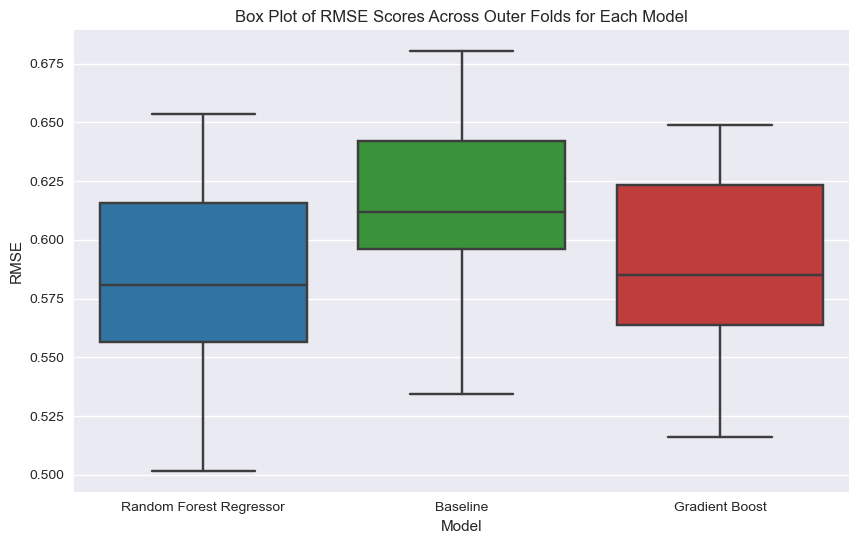

In [91]:
results['Model'] = results['Model'].replace({
    "RandomForestRegressor(random_state=3)": "Random Forest Regressor",
    "baseline": "Baseline",
    "GradientBoostingRegressor(random_state=3)": "Gradient Boost"
})

color_palette = {
    'Random Forest Regressor': '#1f77b4',  # Blue
    'Baseline': '#2ca02c',  # Green
    'Gradient Boost': '#d62728'  # Red
}

plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='RMSE', data=results, palette=color_palette)
plt.title('Box Plot of RMSE Scores Across Outer Folds for Each Model')
plt.ylabel('RMSE')
plt.show()


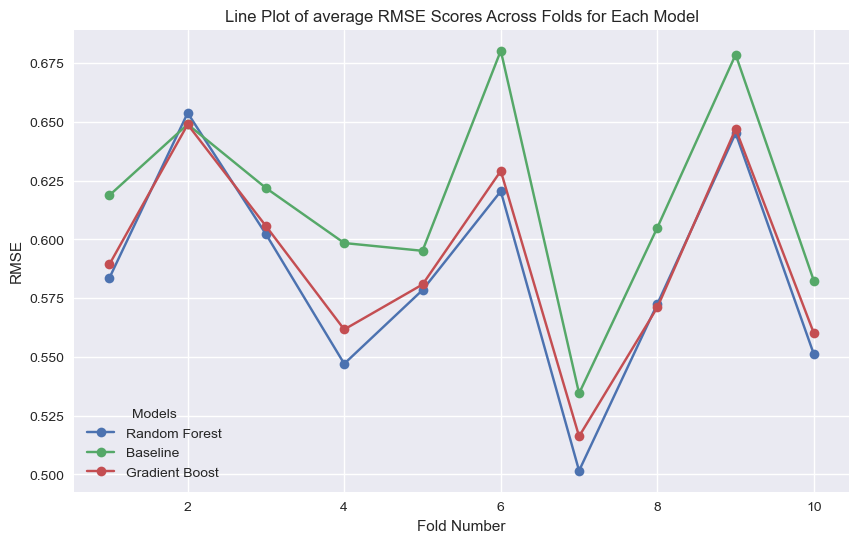

In [95]:
plt.figure(figsize=(10, 6))
for model_name in scores_per_model:
    fold_numbers = list(range(1, len(scores_per_model[model_name]) + 1))
    plt.plot(fold_numbers, scores_per_model[model_name], marker='o', label=model_name)

plt.xlabel('Fold Number')
plt.ylabel('RMSE')
plt.title('Line Plot of average RMSE Scores Across Folds for Each Model')
plt.legend(["Random Forest", "Baseline", "Gradient Boost"], title="Models")
plt.show()



In [94]:
from scipy.stats import ttest_rel, wilcoxon
import numpy as np

# Example RMSE scores (replace these with your actual scores from the plot)


# Extract the scores for the models to compare
rf_scores = scores_per_model["RandomForestRegressor(random_state=3)"]
baseline_scores = scores_per_model["baseline"]
gb_scores = scores_per_model["GradientBoostingRegressor(random_state=3)"]


# Perform Wilcoxon signed-rank test between RandomForest and GradientBoosting
w_stat, p_value_wilcoxon_rf_gb = wilcoxon(rf_scores, gb_scores)
print("Wilcoxon signed-rank test RF vs. GB: w-statistic = {:.3f}, p-value = {:.3f}".format(w_stat, p_value_wilcoxon_rf_gb))

# Perform Wilcoxon signed-rank test between RandomForest and baseline
w_stat, p_value_wilcoxon_rf_baseline = wilcoxon(rf_scores, baseline_scores)
print("Wilcoxon signed-rank test RF vs. Baseline: w-statistic = {:.3f}, p-value = {:.3f}".format(w_stat, p_value_wilcoxon_rf_baseline))

# Perform Wilcoxon signed-rank test between GradientBoosting and baseline
w_stat, p_value_wilcoxon_gb_baseline = wilcoxon(gb_scores, baseline_scores)
print("Wilcoxon signed-rank test GB vs. Baseline: w-statistic = {:.3f}, p-value = {:.3f}".format(w_stat, p_value_wilcoxon_gb_baseline))

# Interpret the results
def interpret_results(p_value, model1, model2):
    if p_value < 0.05:
        print(f"The test suggests that there is a significant difference between {model1} and {model2}.")
    else:
        print(f"The test suggests that there is no significant difference between {model1} and {model2}.")


interpret_results(p_value_wilcoxon_rf_gb, "RandomForestRegressor", "GradientBoostingRegressor")
interpret_results(p_value_wilcoxon_rf_baseline, "RandomForestRegressor", "Baseline")
interpret_results(p_value_wilcoxon_gb_baseline, "GradientBoostingRegressor", "Baseline")

Wilcoxon signed-rank test RF vs. GB: w-statistic = 6.000, p-value = 0.027
Wilcoxon signed-rank test RF vs. Baseline: w-statistic = 1.000, p-value = 0.004
Wilcoxon signed-rank test GB vs. Baseline: w-statistic = 0.000, p-value = 0.002
The test suggests that there is a significant difference between RandomForestRegressor and GradientBoostingRegressor.
The test suggests that there is a significant difference between RandomForestRegressor and Baseline.
The test suggests that there is a significant difference between GradientBoostingRegressor and Baseline.


In [74]:

from sklearn.model_selection import train_test_split
rf_reg_fin = RandomForestRegressor(max_depth=3, max_features=5, n_estimators=10000,random_state=3,min_samples_leaf=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=7)

baseline = np.mean(y_train)
baseline_predictions = np.full((len(y_test),), baseline)

rf_reg_fin.fit(X_train, y_train)

y_pred = rf_reg_fin.predict(X_test)


print("Model abseloute error: ", metrics.mean_absolute_error(y_test, y_pred))
print("Baseline abseloute error: ", metrics.mean_absolute_error(y_test, baseline_predictions))

Model abseloute error:  0.43460239181233845
Baseline abseloute error:  0.4508258817685047


In [84]:
# Sample feature importances and feature names
importances = rf_reg_fin.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_reg_fin.estimators_], axis=0)
feature_names = df.drop(["N_level", "N","POINTID"], axis=1).columns

# Combine feature names and their importances into a DataFrame
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})


categorical_features_mapping = {
    'climate': ['climate_BSk', 'climate_Cfa', 'climate_Cfb', 'climate_Dfb', 'climate_Dfc',"climate_Csa","climate_Csb"],
    'season': ['season_Fall', 'season_Spring', 'season_Summer', 'season_Winter'] 
}

# Function to map one-hot encoded features back to their original feature
def map_to_original_feature(feature_name, mapping):
    for original_feature, encoded_features in mapping.items():
        if feature_name in encoded_features:
            return original_feature
    return feature_name

# Map one-hot encoded features to their original feature
importance_df['original_feature'] = importance_df['feature'].apply(lambda x: map_to_original_feature(x, categorical_features_mapping))

# Aggregate importances by original feature
aggregated_importance_df = importance_df.groupby('original_feature')['importance'].sum().reset_index()

# Sort by importance in descending order
sorted_aggregated_importance_df = aggregated_importance_df.sort_values(by='importance', ascending=False)

# Print the sorted feature importances
for index, row in sorted_aggregated_importance_df.iterrows():
    print(f"Feature: {row['original_feature']}, Importance: {row['importance']}")


Feature: climate, Importance: 0.35771047049121524
Feature: soil_water_all, Importance: 0.1702244629196178
Feature: soil_temp_all, Importance: 0.13149630156748704
Feature: msavi2, Importance: 0.07066479546669033
Feature: ci, Importance: 0.07001206103943357
Feature: ndvi, Importance: 0.0653869213203116
Feature: ndmi, Importance: 0.062076343402690366
Feature: evi, Importance: 0.060010879726503756
Feature: season, Importance: 0.012417764066050437


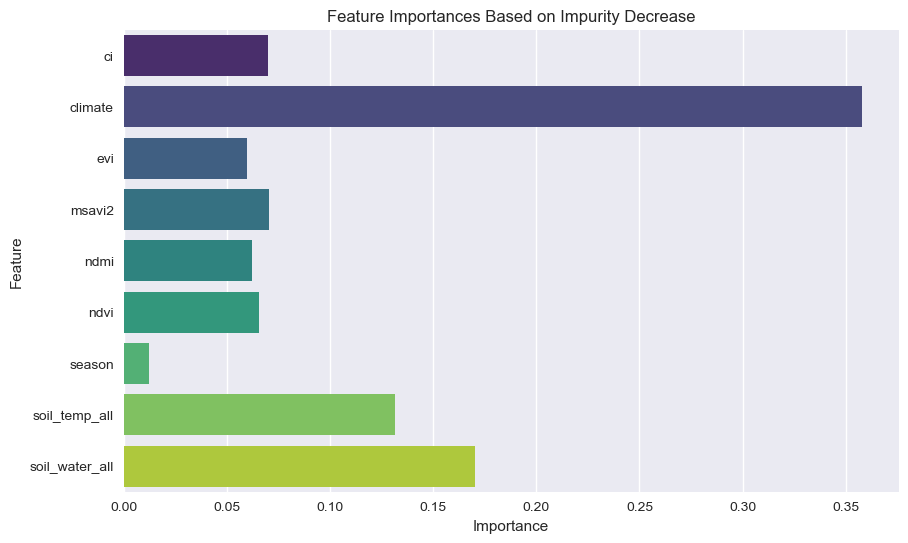

In [85]:
# Plotting the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='original_feature', data=aggregated_importance_df, palette='viridis' )
plt.title('Feature Importances Based on Impurity Decrease')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()